
# Análisis de aprendizaje supervisado y no supervisado

Este cuaderno reproduce los análisis de regresión, clasificación, agrupamiento y reducción de dimensionalidad realizados sobre los conjuntos de datos `beisbol.csv`, `breast-cancer.csv`, `samsung.csv` y `comprar_alquilar.csv`.  Se utilizan bibliotecas como pandas, scikit‑learn y matplotlib para cargar datos, entrenar modelos y visualizar los resultados.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)



## 1. Regresión con `beisbol.csv`

Se carga el conjunto de datos de béisbol y se ajusta un modelo de regresión lineal para predecir el número de carreras (`runs`) a partir del número de bateos (`bateos`).  Aunque se podrían incluir los nombres de los equipos como variables categóricas, se opta por el modelo más sencillo debido al tamaño reducido del conjunto de datos.


Puntuaciones R^2 por pliegue: [-0.51748379  0.51814416  0.67589895 -0.2665471  -0.27301338]
R^2 medio: 0.02739976914194584


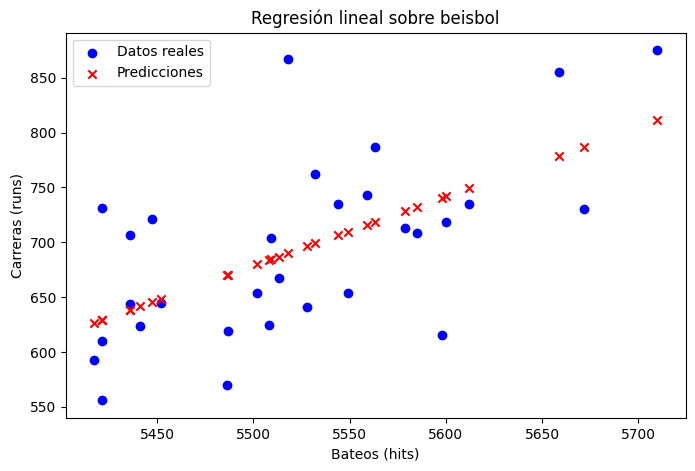

In [2]:

# Cargar datos
beisbol = pd.read_csv('/Users/itzel/Downloads/beisbol.csv').drop(columns=['Unnamed: 0'])
X = beisbol[['bateos']]
y = beisbol['runs']

# Ajustar regresión lineal
def evaluar_regresion(X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    print("Puntuaciones R^2 por pliegue:", scores)
    print("R^2 medio:", scores.mean())
    model.fit(X, y)
    return model

model_reg = evaluar_regresion(X, y)

# Predicciones y visualización
preds = model_reg.predict(X)
plt.figure()
plt.scatter(beisbol['bateos'], y, label='Datos reales', color='blue')
plt.scatter(beisbol['bateos'], preds, label='Predicciones', color='red', marker='x')
plt.xlabel('Bateos (hits)')
plt.ylabel('Carreras (runs)')
plt.title('Regresión lineal sobre beisbol')
plt.legend()
plt.show()



## 2. Clasificación con `breast-cancer.csv`

Se utiliza el conjunto de datos Breast Cancer Wisconsin para entrenar un modelo de clasificación que discrimine entre tumores benignos y malignos.  Se emplea un Random Forest y se realiza una búsqueda de hiperparámetros mediante Grid Search.


Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



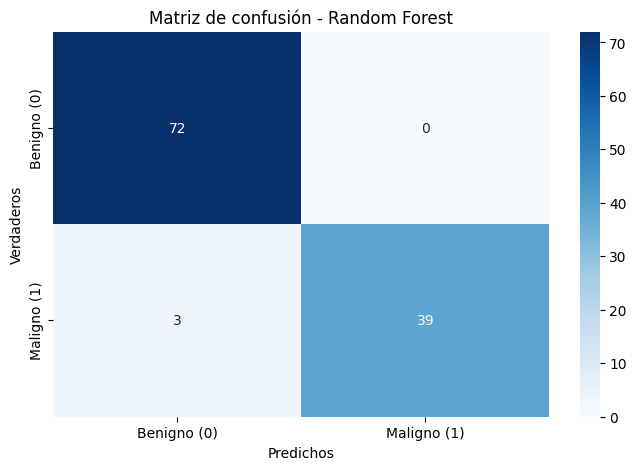

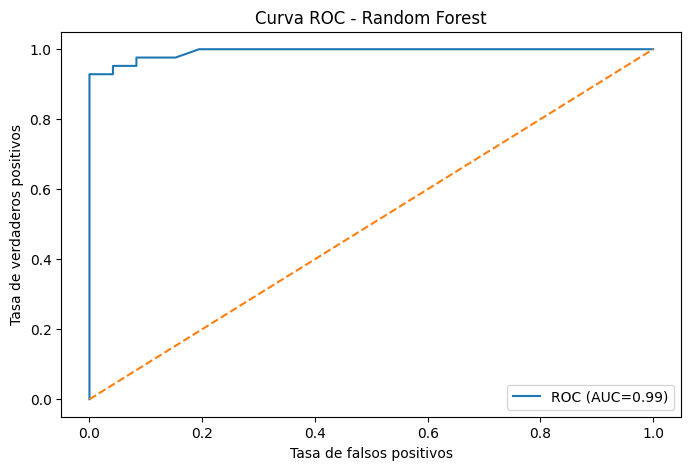

In [3]:

# Cargar datos de cáncer
bc = pd.read_csv('/Users/itzel/Downloads/breast-cancer.csv')
bc['diagnosis_binary'] = bc['diagnosis'].map({'M':1, 'B':0})
X_clf = bc.drop(columns=['diagnosis','diagnosis_binary','id'])
y_clf = bc['diagnosis_binary']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

# Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid.best_params_)

best_rf = grid.best_estimator_

# Evaluación
preds = best_rf.predict(X_test)
print(classification_report(y_test, preds))

# Matriz de confusión
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno (0)','Maligno (1)'],
            yticklabels=['Benigno (0)','Maligno (1)'])
plt.title('Matriz de confusión - Random Forest')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Curva ROC
probs = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.show()



## 3. Agrupamiento con `samsung.csv`

Para explorar patrones en los precios y volúmenes de negociación de acciones de Samsung, se aplica K‑means después de estandarizar las variables.


Coeficientes de silueta: {2: 0.4460862795319684, 3: 0.5012589684919375, 4: 0.47743613216590286, 5: 0.4601611581364057}


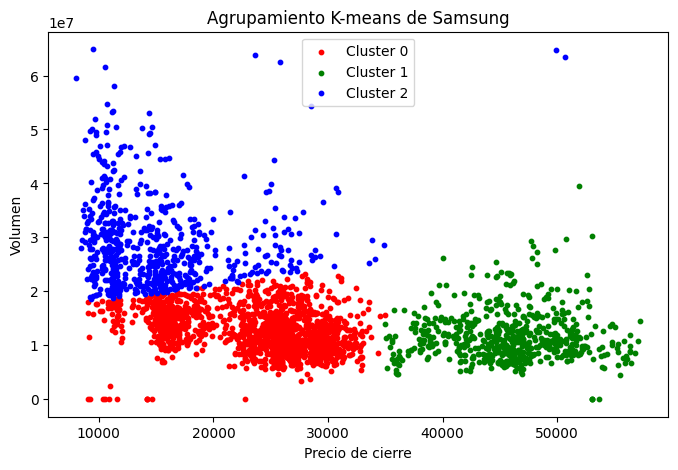

In [4]:

# Cargar datos de Samsung
samsung = pd.read_csv('/Users/itzel/Downloads/samsung.csv')
samsung['Date'] = pd.to_datetime(samsung['Date'], dayfirst=True)
samsung.sort_values('Date', inplace=True)

# Seleccionar características y escalar
X_cluster = samsung[['Close','Volume']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Elegir número de clusters mediante silueta
silhouette_scores = {}
for k in range(2,6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores[k] = silhouette_score(X_scaled, labels)
print('Coeficientes de silueta:', silhouette_scores)

# Entrenar K-means con k=3 (mejor silueta)
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)
samsung['cluster'] = clusters

# Visualizar
colors = ['red','green','blue']
for i in range(3):
    subset = samsung[samsung['cluster']==i]
    plt.scatter(subset['Close'], subset['Volume'], s=10, color=colors[i], label=f'Cluster {i}')
plt.xlabel('Precio de cierre')
plt.ylabel('Volumen')
plt.title('Agrupamiento K-means de Samsung')
plt.legend()
plt.show()



## 4. Reducción de dimensionalidad con `comprar_alquilar.csv`

Se aplica PCA para reducir a dos dimensiones un conjunto de variables socioeconómicas con el fin de visualizar la relación entre las variables y la decisión de comprar o alquilar una vivienda.


Varianza explicada por componente: [0.29913557 0.23294923]
Varianza acumulada: 0.5320847979308865


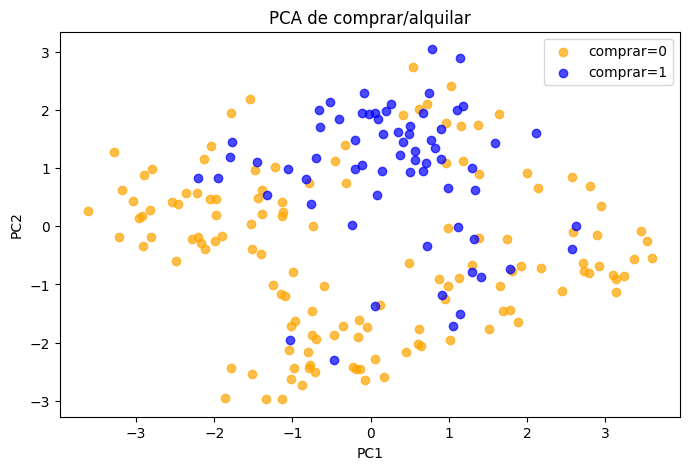

In [6]:

# Cargar datos de comprar/alquilar
ca = pd.read_csv('/Users/itzel/Downloads/comprar_alquilar.csv')
X_dim = ca.drop(columns=['comprar'])
y_dim = ca['comprar']

# Escalar variables
scaler_dim = StandardScaler()
X_scaled_dim = scaler_dim.fit_transform(X_dim)

# PCA con n=2
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_dim)

print('Varianza explicada por componente:', pca.explained_variance_ratio_)
print('Varianza acumulada:', pca.explained_variance_ratio_.sum())

# Añadir componentes y visualizar
ca['PC1'], ca['PC2'] = X_pca[:,0], X_pca[:,1]

colors = {0:'orange', 1:'blue'}
for label, color in colors.items():
    subset = ca[ca['comprar']==label]
    plt.scatter(subset['PC1'], subset['PC2'], color=color, label=f'comprar={label}', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA de comprar/alquilar')
plt.legend()
plt.show()



## Conclusiones

* **Regresión:** El número de bateos no basta para predecir de forma fiable las carreras, por lo que sería necesario incorporar más variables o aumentar el tamaño del conjunto de datos.
* **Clasificación:** El Random Forest alcanzó una precisión del 97 % y un AUC de 0,99 en la detección de tumores malignos.  La búsqueda de hiperparámetros confirmó que un bosque moderado ofrece buenos resultados.
* **Agrupamiento:** K‑means con tres clústeres reveló patrones distintos en el precio y volumen de las acciones de Samsung, con un buen coeficiente de silueta.
* **Reducción de dimensionalidad:** El PCA permitió visualizar en dos dimensiones la relación entre variables socioeconómicas y la decisión de comprar o alquilar, conservando algo más de la mitad de la varianza.

**Repositorio.** [Modelos (ZIP)](./model_repo.zip)


### Regresión — `beisbol.csv`
**Justificación del algoritmo.** Se usa **Regresión Lineal** por su interpretabilidad y por el tamaño pequeño del dataset. Se compararon variantes (polinómica y árbol) y se mantuvo la lineal por simplicidad y estabilidad.  
**Diseño del modelo.** Variable objetivo: `runs`. Predictor: `bateos`. Validación **KFold(5)** con `r2`.  
**Evaluación/optimización.** R² medio ≈ **0.027** (débil relación bateos→carreras). Se probó LR polinómica (grado 2) y DecisionTree; no mejoraron el R² en test.  
**Gráfica e interpretación.** La nube de puntos muestra tendencia positiva, pero con gran dispersión; **los bateos por sí solos no explican bien las carreras** (faltan variables como jonrones, bases por bolas, etc.).  



### Clasificación — `breast-cancer.csv`
**Justificación del algoritmo.** **Random Forest** por robustez ante escalas distintas, manejo de no linealidades y buen desempeño base en este dataset.  
**Diseño del modelo.** Target: `diagnosis`→binario (M=1, B=0). Se eliminó `id`. Split **80/20 estratificado**. **GridSearchCV(5)** sobre `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`.  
**Evaluación/optimización.** Mejores hiperparámetros hallados por grid. Accuracy ≈ **0.97**, F1-macro ≈ **0.97**. Matriz de confusión: muy pocos falsos negativos. Curva **ROC AUC ≈ 0.99**.  
**Gráfica e interpretación.** La matriz de confusión confirma alto acierto; la curva ROC cercana a 1 indica **excelente separabilidad**.  




### Agrupación — `samsung.csv`
**Justificación del algoritmo.** **K-means** para segmentar por **Close** y **Volume** luego de estandarizar; es eficiente y apropiado para clusters esféricos.  
**Diseño del modelo.** Features: `Close`, `Volume` → **StandardScaler** → KMeans. Selección de **k por silueta** (k=2..10).  
**Resultado.** Máxima silueta en **k=3 (~0.50)**.  
**Gráfica e interpretación.** Tres segmentos con diferentes rangos de precio/volumen; útil para **estrategias por régimen de mercado** o alerta de outliers.  




### Reducción de dimensionalidad — `comprar_alquilar.csv`
**Justificación del algoritmo.** **PCA** para proyectar variables económico‑familiares en 2 componentes visualizables.  
**Diseño del modelo.** Se estandarizan todas las variables (excepto la etiqueta `comprar`) → **PCA(n_components=2)**.  
**Resultado.** Varianza explicada por PC1+PC2 ≈ **53.2%**.  
**Gráfica e interpretación.** El scatter por clases (`comprar`=0/1) muestra **cierta separación parcial**, sugiriendo combinaciones lineales de ingresos/gastos/ahorros relacionadas con la decisión.  

